In [78]:
import requests
import urllib
import pandas as pd
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## helper functions

In [67]:
def get_headers():
    headers = {'Accept-Language': 'en-US;q=0.9,en;q=0.8', 
               'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
               AppleWebKit/537.36 (KHTML, like Gecko) \
               Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1823.79'}
    return headers

In [68]:
def get_page_from_imdb(url):
    response = requests.get(url, headers=get_headers())
    assert response.status_code == 200
    return response.text

In [69]:
def get_page_soup(url, concat_string='', use_cache=False, force_update=False):
    url += concat_string
    if use_cache:
        global cache
        if url not in cache or force_update:
            cache[url] = get_page_from_imdb(url)
        page_soup = BeautifulSoup(cache[url])
    else:
        page_soup = BeautifulSoup(get_page_from_imdb(url))
    return page_soup

In [70]:
def get_canonical_url(page_soup):
    canonical_url = page_soup.find('link', attrs={'rel': 'canonical'}).attrs['href']
    return canonical_url

## get_movies_by_actor_soup()

In [71]:
def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None, include_voice=True):
   actor_section = actor_page_soup.find('div', attrs={'id': ['filmo-head-actor', 'filmo-head-actress']})
   try:
      movie_section = actor_section.find_next_sibling('div', attrs={'class': 'filmo-category-section'})
      movie_records = movie_section.find_all('div', attrs={'class': ['filmo-row odd', 'filmo-row even']})
      canonical_url = get_canonical_url(actor_page_soup)
      actor_movies = [(record.contents[3].text, 
                        urllib.parse.urljoin(
                           canonical_url, record.contents[3].contents[0]['href'].split('?')[0])) 
                        for record in movie_records 
                        if record.contents[4].text.strip() == ''
                        and (eval('"(voice)" not in record.contents[6]') if not include_voice else True)]
   except:
      return [(None, None)]
   return actor_movies[:num_of_movies_limit]

## get_movie_descriptions_by_actor_soup()

In [75]:
def get_movie_descriptions_by_actor_soup(actor_page_soup):
    actor_movies = get_movies_by_actor_soup(actor_page_soup)
    movie_descriptions = []
    for movie in actor_movies:
        try: 
            movie_page_soup = get_page_soup(movie[1], concat_string='plotsummary/')
            summaries_section = movie_page_soup.find('div', attrs={'data-testid': 'sub-section-summaries'})
            summary_items = summaries_section.find_all('li')
            for summary_item in summary_items: summary_item.span.decompose() if summary_item.span else None
            summary_text = " ".join(summary_item.get_text() for summary_item in summary_items)
            movie_descriptions.append(summary_text)
        except:
            pass
    return movie_descriptions

## Collecting movie descriptions

In [76]:
actor_names = [
    'Dwayne Johnson', 'Chris Hemsworth', 'Robert Downey Jr.', 'Akshay Kumar', 'Jackie Chan',
    'Bradley Cooper', 'Adam Sandler', 'Scarlett Johansson', 'Sofia Vergara', 'Chris Evans'
    ]

In [ ]:
for actor in actor_names:
    actor_page_soup = get_page_soup(actor[1], concat_string='fullcredits/')
    descriptions = get_movie_descriptions_by_actor_soup(actor_page_soup)
    df = pd.DataFrame(descriptions, columns=[actor[0]])
    file_name = ('0' + str(actor_names.index(actor) + 1) + '_')[-3:] + actor[0].replace(' ', '_').replace('.', '') + '.csv'
    df.to_csv(file_name, index=False)

## Reading files and plotting wordclouds

Wordcloud image for Dwayne Johnson


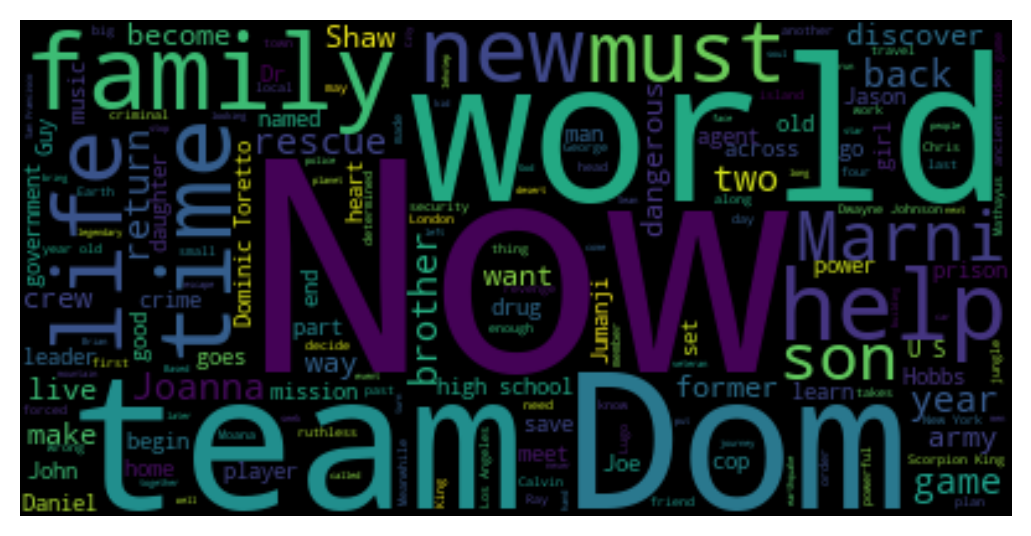

Wordcloud image for Chris Hemsworth


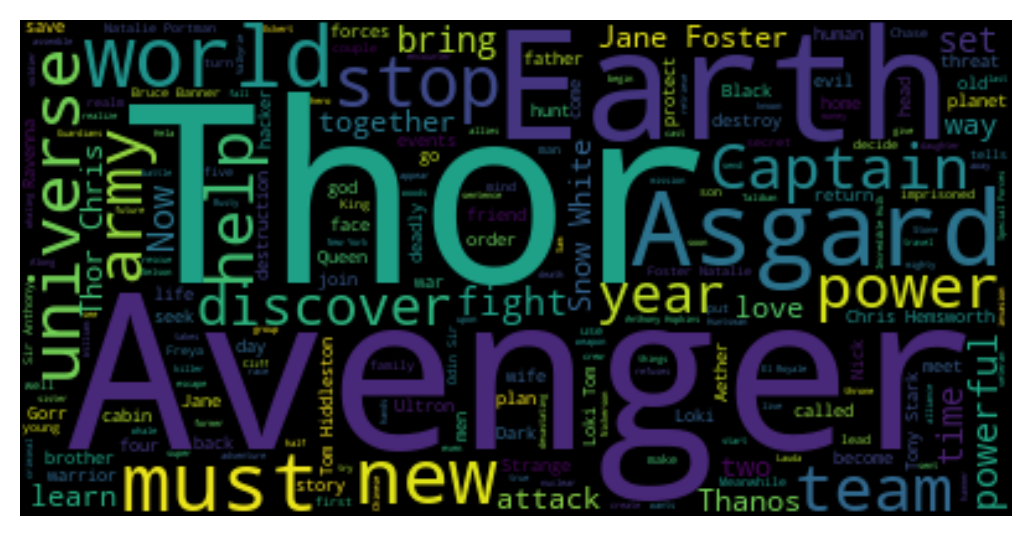

Wordcloud image for Robert Downey Jr.


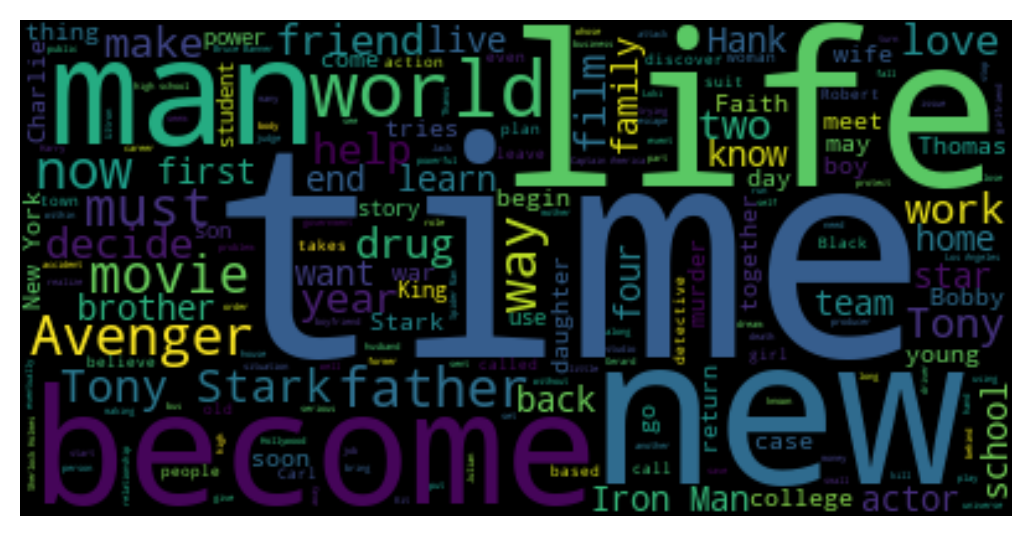

Wordcloud image for Akshay Kumar


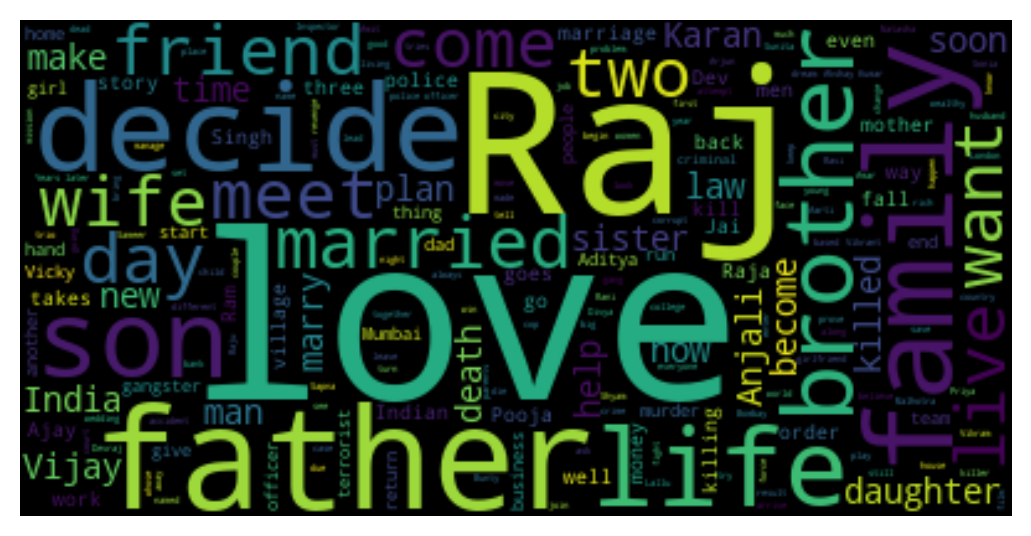

Wordcloud image for Jackie Chan


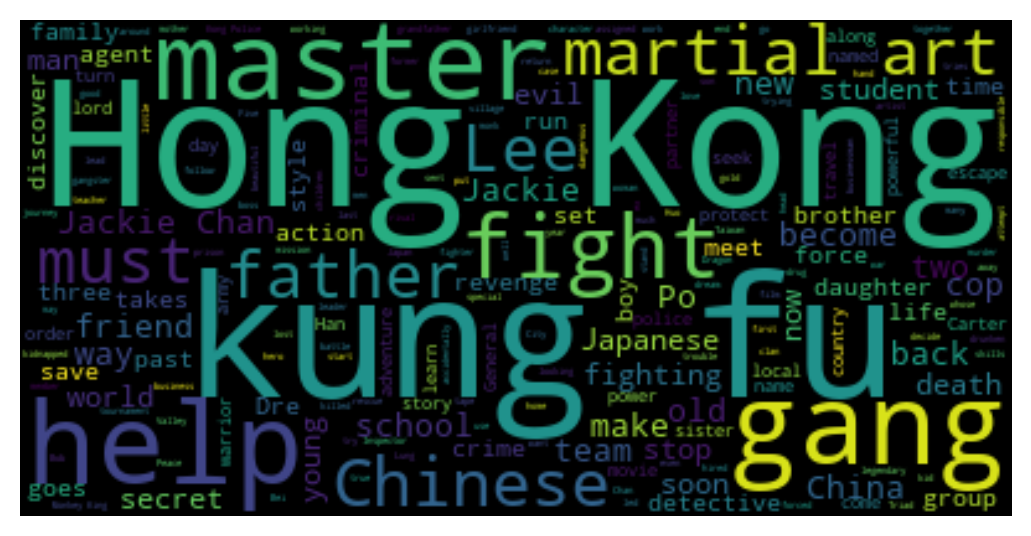

Wordcloud image for Bradley Cooper


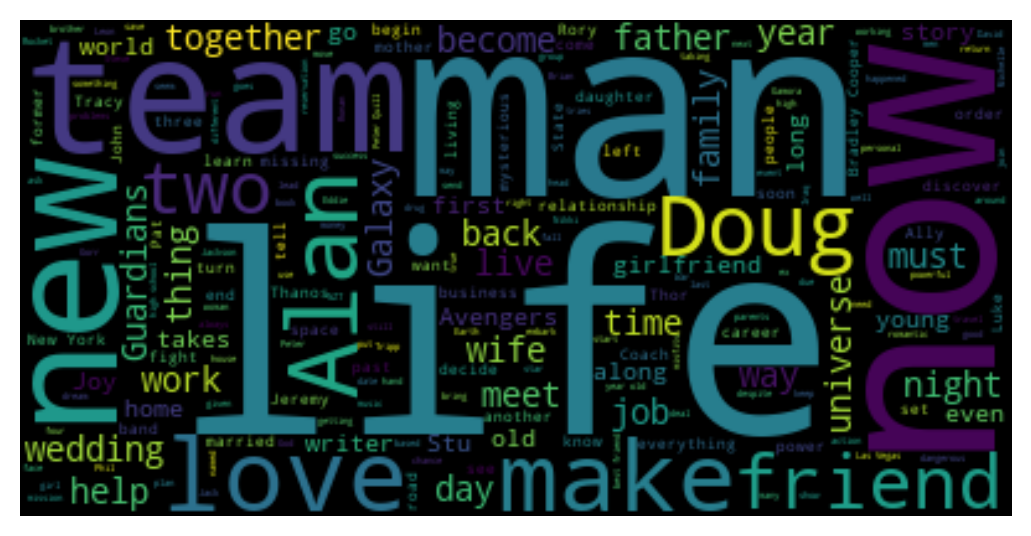

Wordcloud image for Adam Sandler


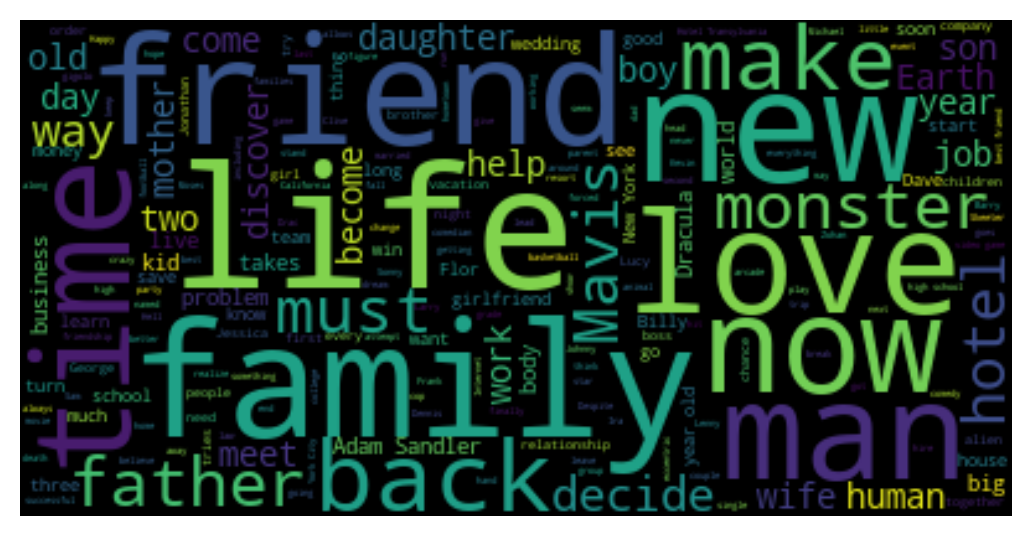

Wordcloud image for Scarlett Johansson


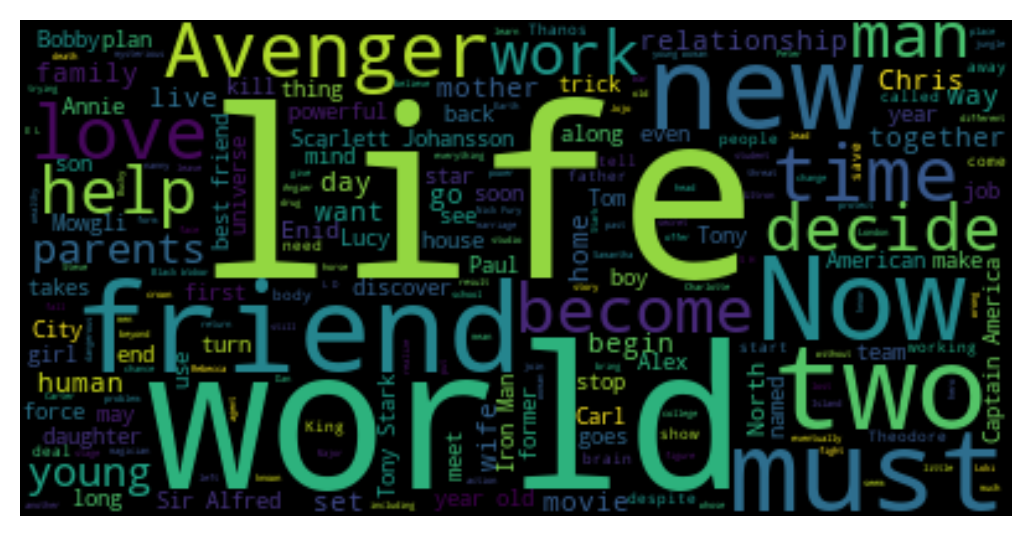

Wordcloud image for Sofia Vergara


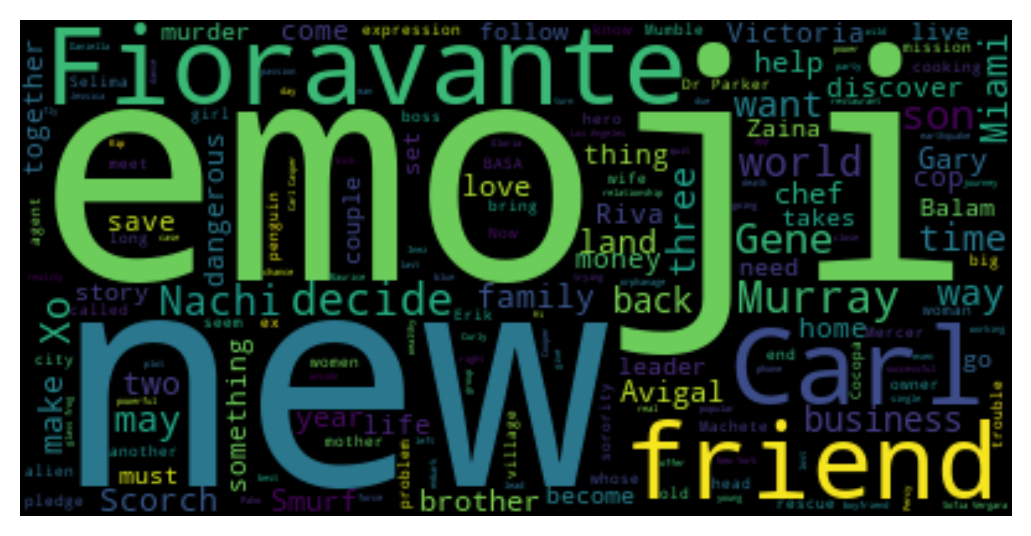

Wordcloud image for Chris Evans


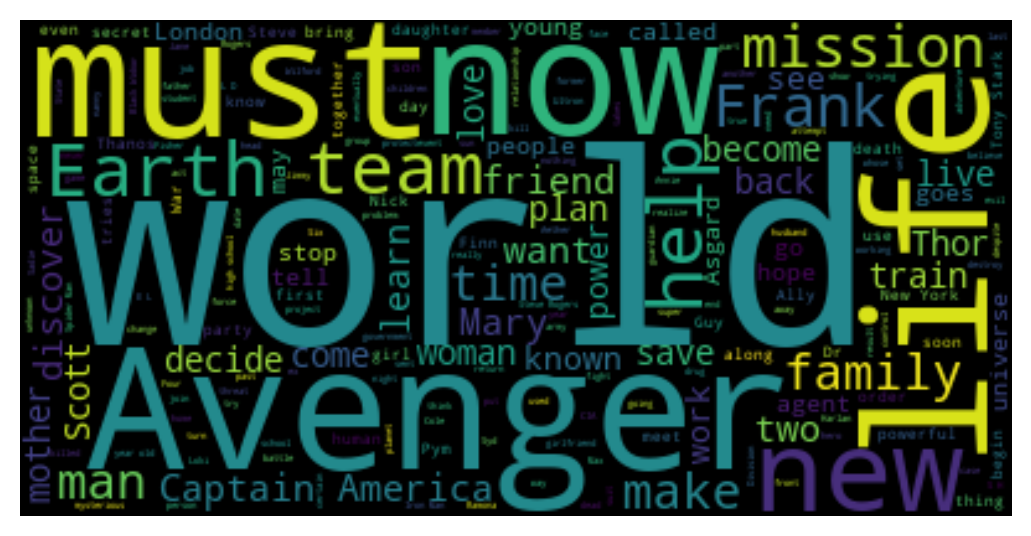

In [61]:
stopwords = set(STOPWORDS)
stopwords.update(['find', 'finds', 'get', 'gets', 'take', 'will', 'one'])


for actor in actor_names:
    file_name = ('0' + str(actor_names.index(actor) + 1) + '_')[-3:] + actor.replace(' ', '_').replace('.', '') + '.csv'
    df = pd.read_csv(file_name)
    text = ' '.join(df[actor])

    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    print(f'Wordcloud image for {actor}')

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
